# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [12]:
import zipfile
import os
import pandas as pd
import numpy as np
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from IPython.display import display
from joblib import Parallel, delayed

In [8]:
# Path to the data
zip_file_path = '../data/final_chembl.zip'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    file_list = z.namelist()

    csv_filename = file_list[0]

    # Read the file as a pandas DataFrame
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)

df.head()

,ChEMBL ID,smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,NumBridgeheadAtoms,LongestAliChain,LargestRing,MolLogLike
0,CHEMBL3897759,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...,13.506757,-0.836612,13.506757,0.011403,0.294586,544.650,510.378,544.276216,...,0,0,0,0,0,0,0,1,6,-12.275704
1,CHEMBL3935110,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...,13.986498,-0.441178,13.986498,0.012570,0.294586,544.650,510.378,544.276216,...,0,0,0,0,0,0,0,1,6,-12.228626
2,CHEMBL3347413,N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1,12.093976,-0.437141,12.093976,0.061471,0.699111,386.238,373.134,385.038482,...,0,0,0,0,0,0,0,2,6,-11.894518
3,CHEMBL1739263,N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1,7.537508,0.042215,7.537508,0.042215,0.410744,378.457,360.313,378.115047,...,0,0,0,1,0,0,0,0,6,-12.655379
4,CHEMBL3917493,O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...,12.517530,-0.360849,12.517530,0.130332,0.363273,400.463,384.335,400.099397,...,0,0,0,1,0,0,0,0,6,-11.901545


In [9]:
# Sub Dataframe of ChEMBL ID and SMILES
smiles_df = df[['ChEMBL ID', 'smiles']].copy()

PandasTools.AddMoleculeColumnToFrame(smiles_df, 'smiles', 'Molecule')

display(smiles_df.head())

,ChEMBL ID,smiles,Molecule
0,CHEMBL3897759,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...
1,CHEMBL3935110,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...
2,CHEMBL3347413,N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...
3,CHEMBL1739263,N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...
4,CHEMBL3917493,O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...


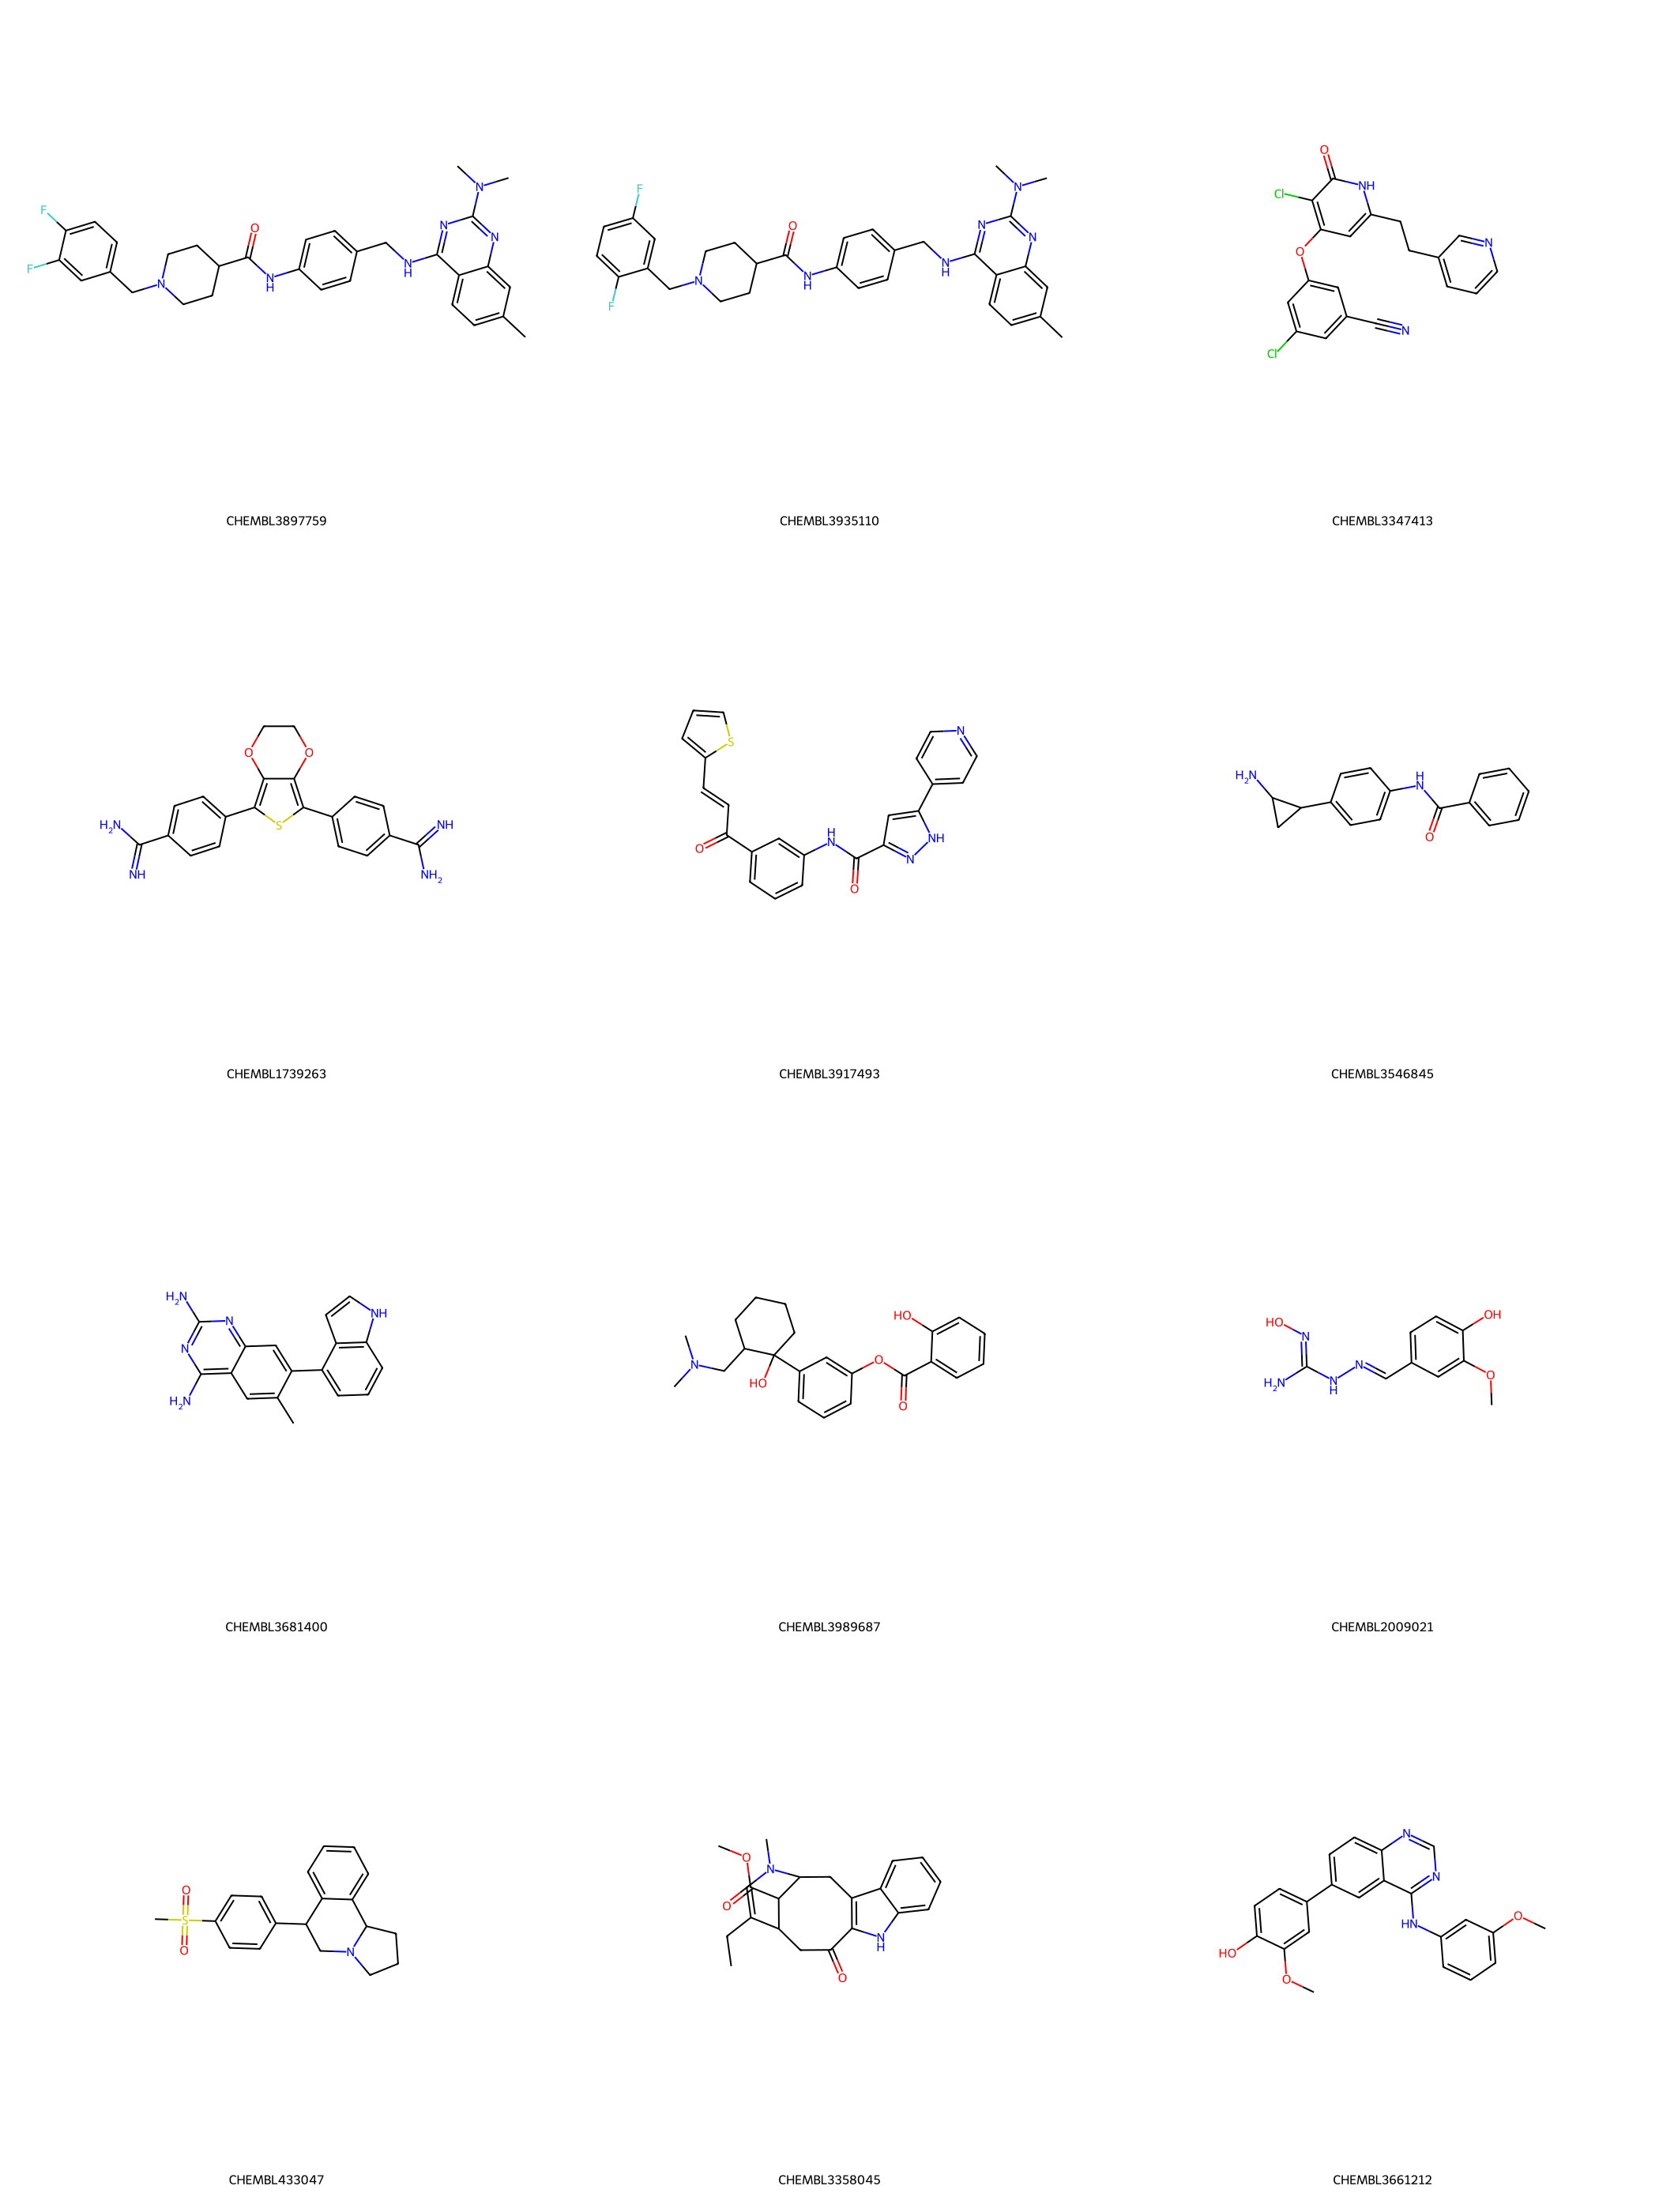

In [13]:
# Prepare molecules and ChEMBL IDs for display (limit to first 10)
mols = smiles_df['Molecule'].tolist()[:12]
ids = smiles_df['ChEMBL ID'].tolist()[:12]

# Display the grid of molecules
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(700, 700), legends=ids)
display(img)

## Convert SMILES to Fingerprints

In [11]:
# Function to generate fingerprint and convert to bit string, creating generator inside the worker
def generate_fingerprint(mol):
    if mol is not None:
        # Create the fingerprint generator inside the worker
        morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgan_generator.GetFingerprint(mol)
        return np.array(list(fp.ToBitString())).astype(int)
    return None

# Use Parallel processing for fingerprint generation
num_cores = -1
fingerprints = Parallel(n_jobs=num_cores)(delayed(generate_fingerprint)(mol) for mol in smiles_df['Molecule'])

# Assign the new column using .loc to avoid the warning
smiles_df.loc[:, 'FingerprintBits'] = fingerprints

# Display the DataFrame with FingerprintBits
smiles_df.head()

,ChEMBL ID,smiles,Molecule,FingerprintBits
0,CHEMBL3897759,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3935110,Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3347413,N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL1739263,N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL3917493,O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...,<rdkit.Chem.rdchem.Mol object at 0x000001FD29B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."


In [14]:
def export_dataframe_to_csv(df, directory, filename):
    # Check if the directory exists, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Construct the full file path
    filepath = os.path.join(directory, filename)

    # Export the DataFrame to CSV
    df.to_csv(filepath, index=False)


# Export the DataFrame to a CSV file
export_dataframe_to_csv(smiles_df, '../data', 'chembl_molecule_fingerprints.csv')